In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import os
import os.path as osp
import pandas as pd

In [ ]:
### CHANGE THIS
PATH = "mobilenet_ckpts2"

In [2]:
history_path = f"{PATH}/history/"
history = []
for f in os.walk(history_path):
    for file in f[2]:
        data = torch.load(osp.join(history_path, file))
        h = dict(epoch=data["epoch"], train_loss=data["loss"]["loss"], val_loss=data["eval_loss"]["loss"]
                )
        for k, v in data["loss"].items():
            h[f"train_{k}"] = v
        for k, v in data["eval_loss"].items():
            h[f"val_{k}"] = v
        history.append(
            h
        )

In [3]:
df = pd.DataFrame(history)
df = df.sort_values("epoch").set_index("epoch")
df.tail()

,train_loss,val_loss,train_top_1_acc,train_top_5_acc,train_top_10_acc,val_top_1_acc,val_top_5_acc,val_top_10_acc
epoch,,,,,,,,
23,1.392070,4.522109,0.611264,0.879848,0.940991,0.216673,0.453521,0.580548
24,1.297419,4.603458,0.631527,0.895656,0.949939,0.208119,0.447191,0.573774
25,1.213996,4.806049,0.652000,0.907497,0.957835,0.207723,0.442445,0.563884
26,1.144975,4.831029,0.670418,0.916728,0.962921,0.212718,0.444373,0.565566
27,1.078215,4.985627,0.687206,0.926247,0.967980,0.209059,0.438884,0.564923


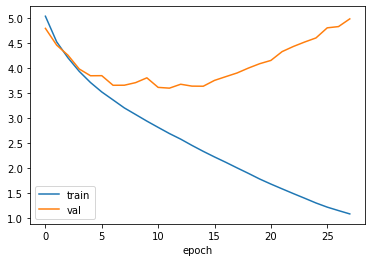

In [4]:
df['train_loss'].plot(label="train")
df['val_loss'].plot(label="val")
plt.legend()

In [7]:
import torchvision.models as models
device=torch.device("cuda")
model = models.mobilenet_v2(pretrained=False, num_classes=200).to(device)

In [16]:
model.load_state_dict(torch.load(f"{PATH}/weights/ckpt_{df['val_loss'].argmin()}.pt")["model_state_dict"])

<All keys matched successfully>

In [11]:
import pickle
with open("dataset.pkl", "rb") as f:
    dataset = pickle.load(f)
dataset["train"] = dataset["train"] / 255
dataset["train"] = dataset["train"].permute(0,3,1,2)
dataset["train"].shape
data_path = "../../tiny-imagenet-200"
classes = pd.read_csv(f"{data_path}/words.txt", sep="\t", names=["id", "entity"])
id_to_label = {}
for _, row in classes.iterrows():
    id_to_label[row['id']] = row['entity']
labels = np.array(dataset['labels'])
label_to_idx = {}
for i, label in enumerate(np.unique(labels)):
    label_to_idx[label] = i
for i in range(len(labels)):
    labels[i] = label_to_idx[labels[i]]
labels = labels.astype(int)
labels = torch.from_numpy(labels)
raw_dataset = []
for i in range(len(labels)):
    raw_dataset.append((dataset["train"][i], labels[i]))

In [12]:
def compute_accs(preds, labels):
    k = 10
    _, ind = torch.topk(preds, k)
    
    accs = {}
    for _k in [1, 5, 10]:
        acc = ind[:,:_k].eq(labels).any(1).sum() / len(labels)
        accs[f"top_{_k}_acc"] = acc
    return accs

import os.path as osp
from collections import defaultdict
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_nb
def evaluate(model, val_dl: DataLoader, verbose=True, nb=False):
    loss_fnc = torch.nn.CrossEntropyLoss()
    model.eval()
    _tqdm = tqdm_nb if nb else tqdm
    if verbose:
        pbar = _tqdm(enumerate(val_dl), total=len(val_dl), position=0, leave=True)
        pbar.set_description("Evaluation Progress")
    with torch.no_grad():
        batch_size = val_dl.batch_size
        avg_loss = defaultdict(int)
        num_train_imgs = len(val_dl.dataset)
        c = 0
        for batch_idx, data in enumerate(val_dl):
            c += 1

            imgs = data[0].to(device)
            labels = data[1].to(device)
            preds = model(imgs)
#             preds = torch.nn.functional.softmax(preds, dim=1)

            loss = {
                "loss": loss_fnc(preds, labels),
                # "acc": 0
            }
            for k, v in compute_accs(preds, labels.view(-1,1)).items():
                loss[k] = v
            for k, v in loss.items():
                avg_loss[k] += v.item()
            if verbose:
                pbar.update()
        for k in avg_loss.keys():
            avg_loss[k] /= c
    model.train()
    if verbose:
        pbar.close()
    return avg_loss
def train(
    model,
    optim: torch.optim.Optimizer,
    epochs: int,
    train_dl: DataLoader,
    val_dl: DataLoader,
    start_epoch=0,
    save_freq=10,
    save_best=True,
    save_dir="./",
    prev_best_loss=np.inf,
    verbose=True,
    nb=False,
    train_cb=None,
):
    """
    train the vae model
    """
    loss_fnc = torch.nn.CrossEntropyLoss()
    _tqdm = tqdm_nb if nb else tqdm
    model.train()
    optimizer_idx = 0
    num_train_imgs = len(train_dl.dataset)
    batch_size = train_dl.batch_size
    if verbose:
        epoch_pbar = _tqdm(range(epochs), position=0, leave=True)
        epoch_pbar.set_description("Progress")
        pbar = _tqdm(enumerate(train_dl), total=len(train_dl), position=0, leave=True)
        pbar.set_description("Current Epoch Progress")
        epoch_pbar.update(start_epoch)
    for epoch in range(start_epoch, start_epoch + epochs):
        avg_loss = defaultdict(int)
        c = 0
        if verbose:
            epoch_pbar.update()
            pbar.reset()
        for batch_idx, data in enumerate(train_dl):

            c += 1
            
            imgs = data[0].to(device)
            labels = data[1].to(device)
            # imgs (B, C=1, W, H)
            optim.zero_grad()
            preds = model(imgs)
#             preds = torch.nn.functional.softmax(preds, dim=1)
            loss = {
                "loss": loss_fnc(preds, labels),
                # "acc": 
            }
            with torch.no_grad():
                for k, v in compute_accs(preds, labels.view(-1,1)).items():
                    loss[k] = v
                for k, v in loss.items():
                    avg_loss[k] += v.item()
            optimizer_idx += 1
            loss["loss"].backward()
            optim.step()
            if verbose:
                pbar.update()
        for k in avg_loss.keys():
            avg_loss[k] /= c
        eval_loss = evaluate(model, val_dl, nb=nb, verbose=False)
        if train_cb:
            train_cb(epoch=epoch, loss=avg_loss, eval_loss=eval_loss, model=model)
        save = False
        if eval_loss["loss"] < prev_best_loss:
            prev_best_loss = eval_loss["loss"]
            if save_best:
                save = True
        if epoch % save_freq == 0 or epoch == epochs - 1:
            save = True
        torch.save(
            dict(
                epoch=epoch,
                loss=avg_loss,
                eval_loss=eval_loss,
                prev_best_loss=prev_best_loss,
            ),
            osp.join(save_dir, f"history/ckpt_{epoch}.pt"),
        )
        if save:
            torch.save(
                dict(
                    model_state_dict=model.state_dict(),
                    optim_State_dict=optim.state_dict(),
                    epoch=epoch,
                    loss=avg_loss,
                    eval_loss=eval_loss,
                    prev_best_loss=prev_best_loss,
                ),
                osp.join(save_dir, f"weights/ckpt_{epoch}.pt"),
            )

In [13]:
from sklearn.utils import shuffle
shuffled_raw_dataset = shuffle(raw_dataset, random_state=3407)
train_raw_dataset = shuffled_raw_dataset[:60000]
val_raw_dataset = shuffled_raw_dataset[60000:60000+20000]
test_raw_dataset = shuffled_raw_dataset[60000+20000:]

In [15]:
test_dl = torch.utils.data.DataLoader(test_raw_dataset, shuffle=False, batch_size=256)
with torch.no_grad():
    model.eval()
    results = evaluate(model=model,val_dl=test_dl)
results

Evaluation Progress: 100%|██████████| 79/79 [00:02<00:00, 28.69it/s]


defaultdict(int,
            {'loss': 3.5916076974023747,
             'top_1_acc': 0.21751384493670886,
             'top_5_acc': 0.4686511075949367,
             'top_10_acc': 0.6010185917721519})

In [28]:
import itertools
num_weights = 0
for p in model.named_parameters():
    x = 1
    for s in p[1].shape:
        x *= s
    num_weights += x

In [29]:
num_weights

2480072

In [30]:
results

defaultdict(int,
            {'loss': 3.5916076974023747,
             'top_1_acc': 0.21751384493670886,
             'top_5_acc': 0.4686511075949367,
             'top_10_acc': 0.6010185917721519})

In [31]:
df['val_loss'].argmin()

11